In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pwd

'/home/omar/Desktop/bigdata'

In [3]:
path_to_application = 'credit-card-approval-prediction/application_record.csv'
applicant_data = pd.read_csv(path_to_application)

display(applicant_data.head())
applicant_data.info()

FileNotFoundError: [Errno 2] No such file or directory: 'credit-card-approval-prediction/application_record.csv'

In [3]:
path_to_credit = 'credit-card-approval-prediction/credit_record.csv'
credit_data = pd.read_csv(path_to_credit)

display(credit_data.head())
credit_data.info()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [4]:
credit_data['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

Since we have two different tables, merge them to get the one with both personal and credit info.
Also to turn the task into binary classification, I decoded the target variable using the label_status func. Now any days past due are set to 0 and paid in time - 1

In [5]:
applicant_data = applicant_data.drop_duplicates(subset='ID', keep='first')

mode_status = credit_data.groupby('ID')['STATUS'].agg(lambda x: x.mode()[0]).reset_index()
mode_status.rename(columns={'STATUS': 'mode_status'}, inplace=True)
mode_status = mode_status[mode_status['mode_status'] != 'X']

merged_df = pd.merge(applicant_data, mode_status, on='ID', how='inner')

In [6]:
def label_status(status):
    if status in {"0", "1", "2", "3", "4", "5"}:
        return 0
    elif status == 'C':
        return 1

In [7]:
merged_df['label'] = merged_df['mode_status'].apply(label_status)
merged_df['label'].value_counts()

label
0    17652
1    12807
Name: count, dtype: int64

In [8]:
categorical_ordinal_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categorical_onehot_columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
numerical_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'mode_status']

In [9]:
# Ordinal Encoding for specified columns
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
merged_df[categorical_ordinal_columns] = ordinal_encoder.fit_transform(merged_df[categorical_ordinal_columns])

In [10]:
# Imputation and One-Hot Encoding for OCCUPATION_TYPE
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

occupation_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
merged_df['OCCUPATION_TYPE'] = occupation_imputer.fit_transform(merged_df[['OCCUPATION_TYPE']]).ravel()
occupation_onehot_encoder = OneHotEncoder()
occupation_onehot_encoded = pd.DataFrame(
    occupation_onehot_encoder.fit_transform(merged_df[['OCCUPATION_TYPE']]),
    columns=occupation_onehot_encoder.get_feature_names_out(['OCCUPATION_TYPE'])
)
merged_df = pd.concat([merged_df, occupation_onehot_encoded], axis=1)
merged_df.drop(columns=['OCCUPATION_TYPE'], inplace=True)

In [11]:
# One-Hot Encoding for categorical_onehot_columns
onehot_encoder = OneHotEncoder()
onehot_encoded = pd.DataFrame(
    onehot_encoder.fit_transform(merged_df[categorical_onehot_columns]),
    columns=onehot_encoder.get_feature_names_out(categorical_onehot_columns)
)
merged_df = pd.concat([merged_df, onehot_encoded], axis=1)
merged_df.drop(columns=categorical_onehot_columns, inplace=True)

In [12]:
# Custom feature engineering for numerical columns
merged_df['AGE'] = abs(merged_df['DAYS_BIRTH']) / 365
merged_df['YEARS_EMPLOYED'] = abs(merged_df['DAYS_EMPLOYED']) / 365
merged_df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'mode_status'], inplace=True, errors='ignore')

In [13]:
merged_df.columns = [col.split('__', 1)[-1] for col in merged_df.columns]

In [14]:
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,AGE,YEARS_EMPLOYED
0,5008804,1.0,1.0,1.0,0,427500.0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32.890411,12.443836
1,5008805,1.0,1.0,1.0,0,427500.0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32.890411,12.443836
2,5008810,0.0,0.0,1.0,0,270000.0,1,0,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.356164,8.358904
3,5008811,0.0,0.0,1.0,0,270000.0,1,0,1,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.356164,8.358904
4,5008812,0.0,0.0,1.0,0,283500.0,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.545205,1000.665753


In [15]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30459 entries, 0 to 30458
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 30459 non-null  int64  
 1   CODE_GENDER                                        30459 non-null  float64
 2   FLAG_OWN_CAR                                       30459 non-null  float64
 3   FLAG_OWN_REALTY                                    30459 non-null  float64
 4   CNT_CHILDREN                                       30459 non-null  int64  
 5   AMT_INCOME_TOTAL                                   30459 non-null  float64
 6   FLAG_MOBIL                                         30459 non-null  int64  
 7   FLAG_WORK_PHONE                                    30459 non-null  int64  
 8   FLAG_PHONE                                         30459 non-null  int64  
 9   FLAG_E

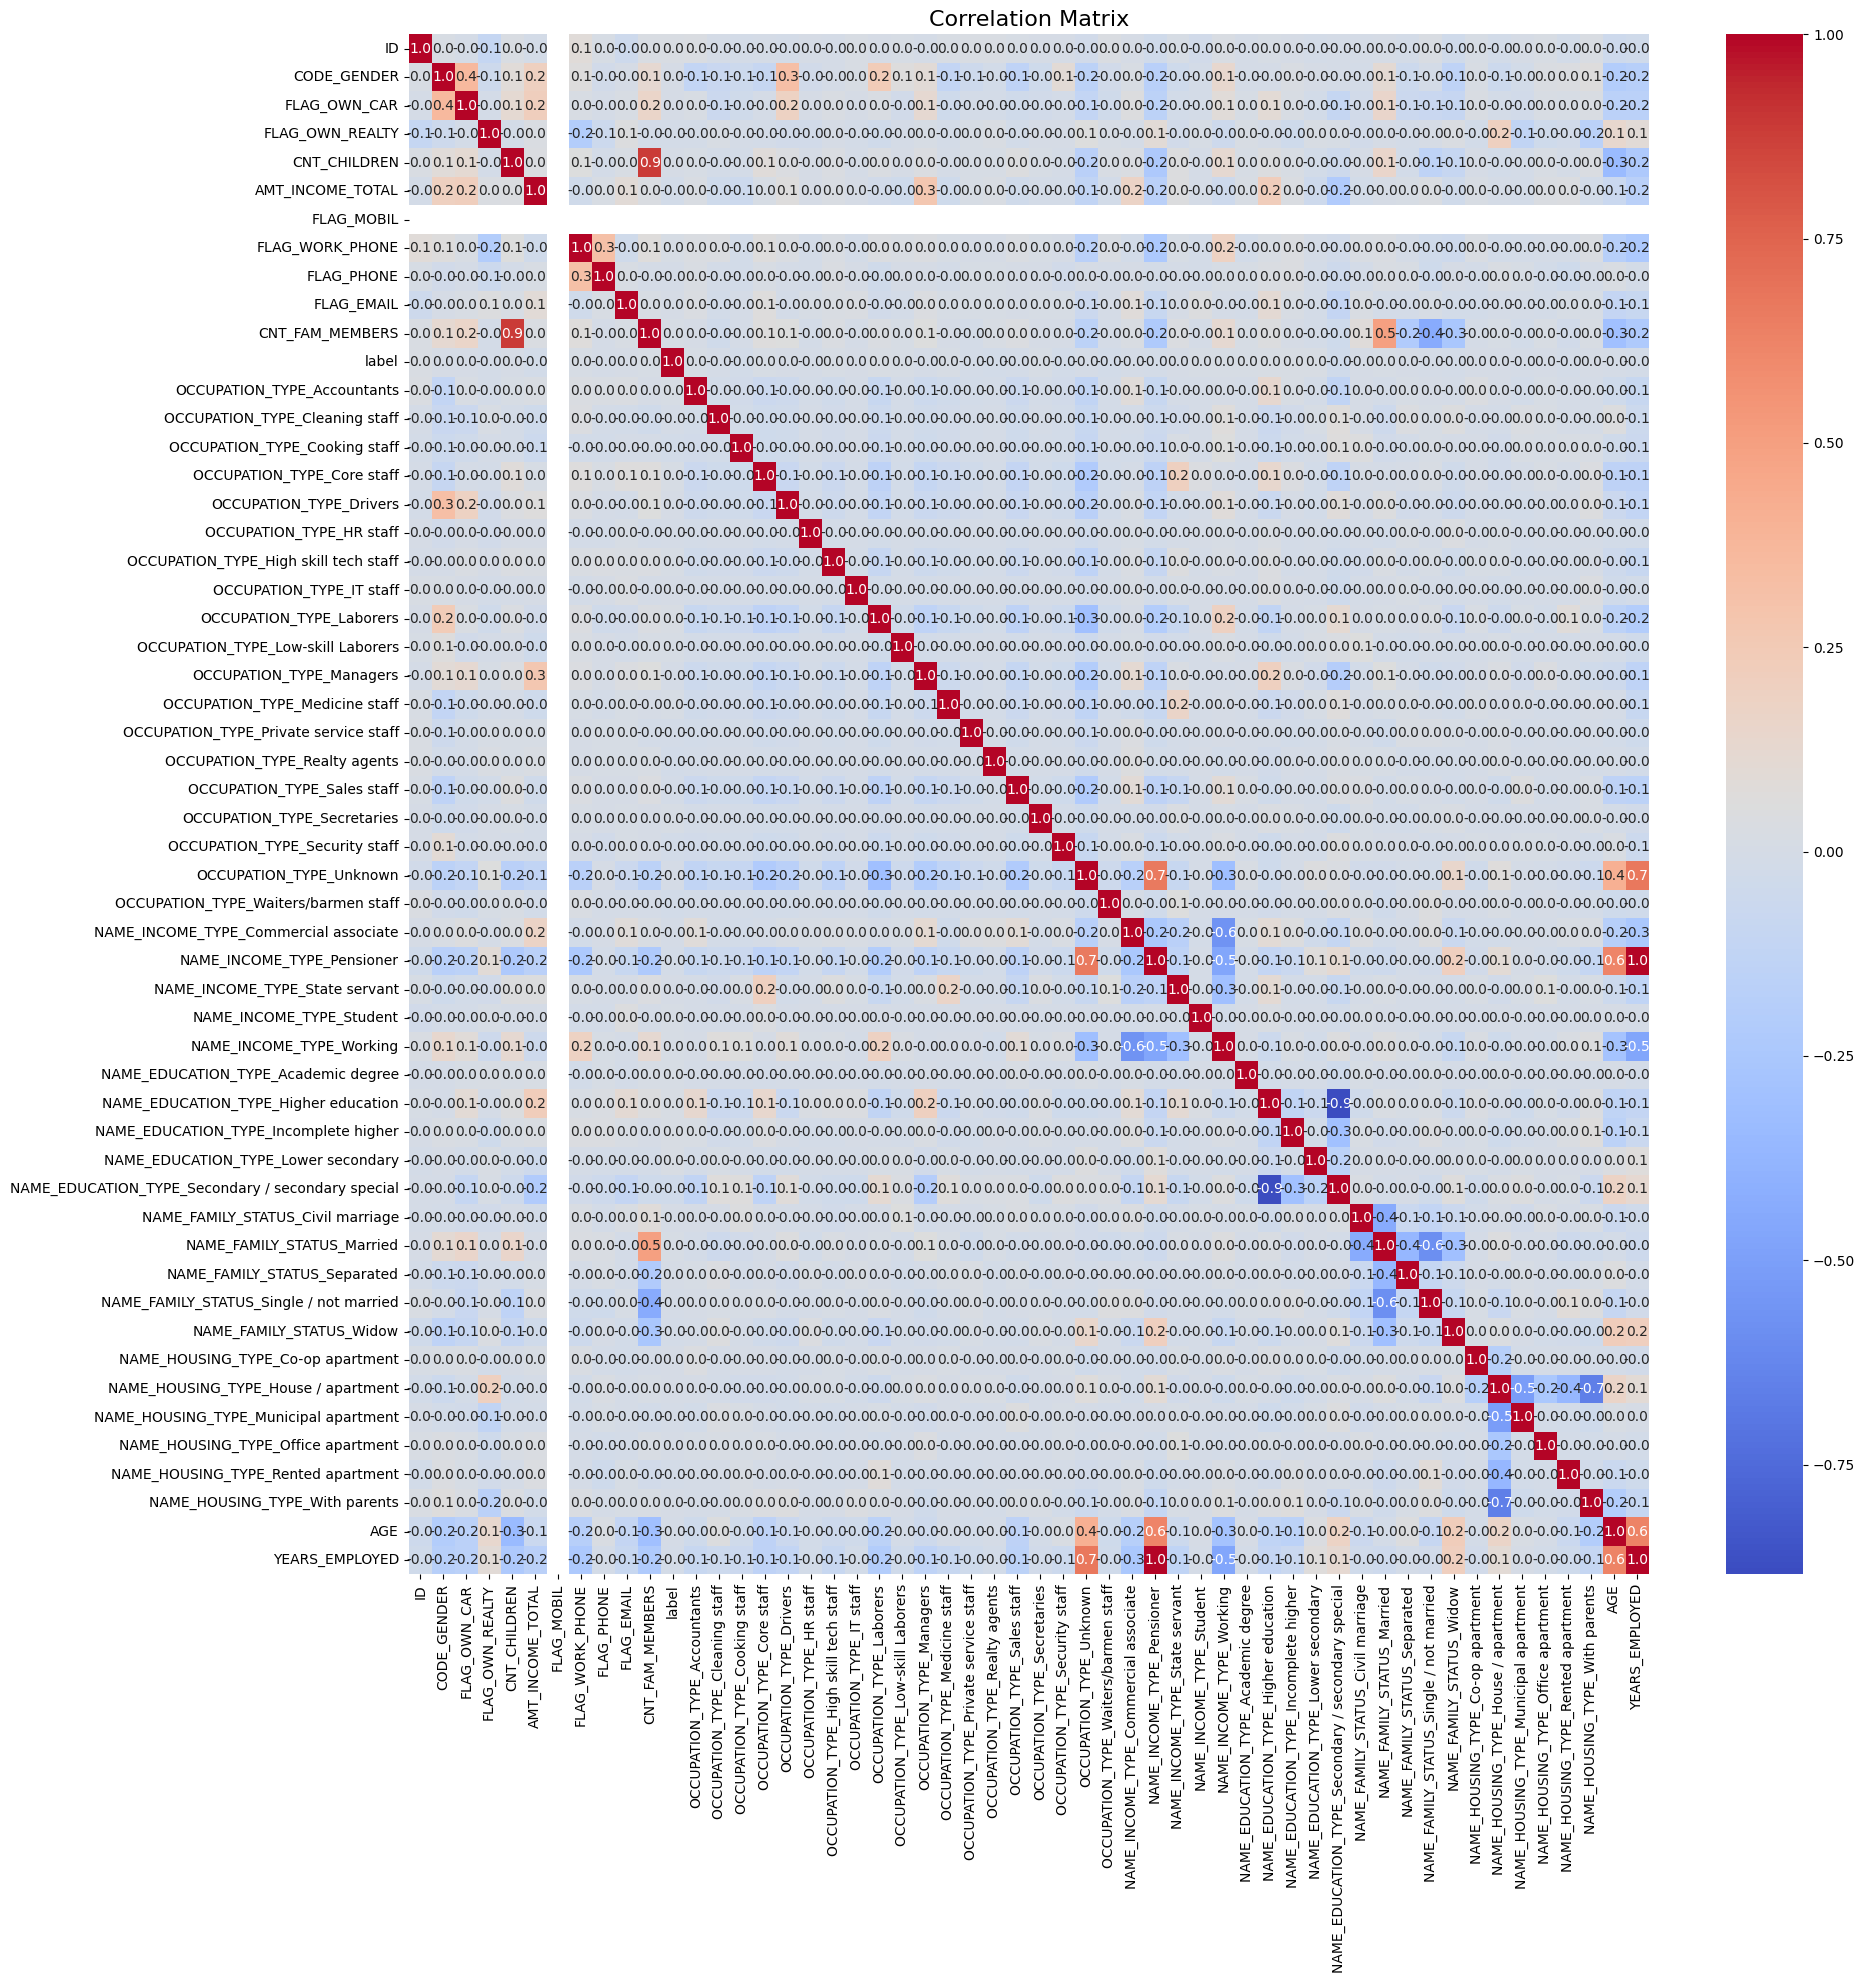

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = merged_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


In [17]:
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
top_corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()
display(top_corr_pairs.head(10))

YEARS_EMPLOYED              NAME_INCOME_TYPE_Pensioner    0.997900
CNT_CHILDREN                CNT_FAM_MEMBERS               0.889129
OCCUPATION_TYPE_Unknown     YEARS_EMPLOYED                0.669949
                            NAME_INCOME_TYPE_Pensioner    0.668670
YEARS_EMPLOYED              AGE                           0.626161
NAME_INCOME_TYPE_Pensioner  AGE                           0.620995
NAME_FAMILY_STATUS_Married  CNT_FAM_MEMBERS               0.498278
AGE                         OCCUPATION_TYPE_Unknown       0.417198
FLAG_OWN_CAR                CODE_GENDER                   0.362537
CODE_GENDER                 OCCUPATION_TYPE_Drivers       0.327564
dtype: float64

In [18]:
merged_df.drop(columns=['NAME_INCOME_TYPE_Pensioner', 'CNT_CHILDREN'], inplace=True)

In [19]:
from sklearn.preprocessing import StandardScaler
def prepare_data(data, label_col, test_size=0.3, random_state=42):
    X = data.drop(columns=[label_col, 'ID'])
    y = data[label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return  X_train_scaled, X_test_scaled, y_train, y_test

In [21]:
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score,classification_report, make_scorer
def evaluate_model(model, data, random_state=42):

    X_train, X_test, y_train, y_test = data

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)# Entraîner le modèle sur les données d'entraînement


    roc_auc = roc_auc_score(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)

    print(f"{model.__class__.__name__} Results:")
    print()
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", round(acc_score,2))
    print("ROC AUC Score:", round(roc_auc,2))

    return model, roc_auc

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(merged_df, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test
log_reg = LogisticRegression(max_iter=1000, random_state=42)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[5256   61]
 [3761   60]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.99      0.73      5317
           1       0.50      0.02      0.03      3821

    accuracy                           0.58      9138
   macro avg       0.54      0.50      0.38      9138
weighted avg       0.55      0.58      0.44      9138

Accuracy Score: 0.58
ROC AUC Score: 0.5


In [23]:
from sklearn.model_selection import  cross_val_score, KFold
log_reg = LogisticRegression(max_iter=1000,  random_state=42)

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=kf, scoring=roc_auc_scorer)
print(f"K-Fold Cross-Validation ROC AUC Scores: {kf_scores}")
print(f"Average ROC AUC (K-Fold): {kf_scores.mean()}")

K-Fold Cross-Validation ROC AUC Scores: [0.51826784 0.53404712 0.52804126 0.52316996 0.51461266]
Average ROC AUC (K-Fold): 0.5236277662361329


Adding new features

In [24]:
merged_df['INCOME_PER_FAM_MEMBER'] = merged_df['AMT_INCOME_TOTAL'] / merged_df['CNT_FAM_MEMBERS']
merged_df['EMPLOYED_TO_AGE_RATIO'] = merged_df['YEARS_EMPLOYED'] / merged_df['AGE']

 Adding Credit History Length

In [25]:
credit_history_length = credit_data.groupby('ID')['MONTHS_BALANCE'].agg(lambda x: x.max() - x.min())
merged_df['CREDIT_HISTORY_LENGTH'] = merged_df['ID'].map(credit_history_length)

Adding Recent Activity Flag

In [26]:
recent_activity_flag = credit_data.groupby('ID')['MONTHS_BALANCE'].agg(lambda x: int(any(x >= -4)))
merged_df['RECENT_ACTIVITY'] = merged_df['ID'].map(recent_activity_flag)

In [27]:
from sklearn.preprocessing import PolynomialFeatures
selected_features = [
    'INCOME_PER_FAM_MEMBER', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED',
    'AGE', 'CREDIT_HISTORY_LENGTH', 'RECENT_ACTIVITY'
]

poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(merged_df[selected_features])
poly_feature_names = poly.get_feature_names_out(selected_features)

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

merged_df_with_poly = pd.concat([merged_df, X_poly_df], axis=1)

In [28]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = prepare_data(merged_df_with_poly, 'label')

prepared_data_poly = X_train_poly, X_test_poly, y_train_poly, y_test_poly

log_reg = LogisticRegression(max_iter=1000, random_state=42)

_, score = evaluate_model(log_reg, prepared_data_poly)

LogisticRegression Results:

Confusion Matrix:
 [[4277 1040]
 [1216 2605]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      5317
           1       0.71      0.68      0.70      3821

    accuracy                           0.75      9138
   macro avg       0.75      0.74      0.74      9138
weighted avg       0.75      0.75      0.75      9138

Accuracy Score: 0.75
ROC AUC Score: 0.74


In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


param_grid = {
    'C': [0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
}

log_reg = LogisticRegression(max_iter=1000,random_state=42)

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1)

grid_search.fit(X_train_poly, y_train_poly)

print("Best Hyperparameters:", grid_search.best_params_)

best_log_reg = grid_search.best_estimator_

_, roc_auc = evaluate_model(best_log_reg, prepared_data_poly)



AssertionError: 

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

param_grid_rf = {
    'n_estimators': 500,
    'min_samples_leaf': 1,
    'bootstrap': True
}

rf = RandomForestClassifier(**param_grid_rf)
_, roc_auc = evaluate_model(rf, prepared_data_poly)

RandomForestClassifier Results:

Confusion Matrix:
 [[4348  969]
 [ 960 2861]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      5317
           1       0.75      0.75      0.75      3821

    accuracy                           0.79      9138
   macro avg       0.78      0.78      0.78      9138
weighted avg       0.79      0.79      0.79      9138

Accuracy Score: 0.79
ROC AUC Score: 0.78


In [31]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

xgb_model = xgb.XGBClassifier()

_, roc_auc = evaluate_model(rf, prepared_data_poly)

RandomForestClassifier Results:

Confusion Matrix:
 [[4354  963]
 [ 960 2861]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      5317
           1       0.75      0.75      0.75      3821

    accuracy                           0.79      9138
   macro avg       0.78      0.78      0.78      9138
weighted avg       0.79      0.79      0.79      9138

Accuracy Score: 0.79
ROC AUC Score: 0.78
